# Imports

In [1]:
import string
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# config

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# load data

In [4]:
emotions_csv = pd.read_csv('NRC-Emotion-Lexicon-v0.92-English.csv', header=0)
emotions_csv.head()

,English,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0


# load emotions into memory while ranking them (prefer negative over positive)

In [5]:
all_emotions = {
    'Anger': (1, 'negative'), 
    'Fear': (2, 'negative'),  
    'Disgust': (3, 'negative'), 
    'Sadness': (4, 'negative'),  
    'Surprise': (5, 'negative'),  
    'Anticipation': (6, 'positive'),  
    'Joy': (7, 'positive'),   
    'Trust': (8, 'positive'), 
}

pos_emotions = {
    'Anticipation': (1, 'positive'),  
    'Joy': (2, 'positive'),   
    'Trust': (3, 'positive')
}

neg_emotions = {
    'Anger': (1, 'negative'), 
    'Fear': (2, 'negative'),  
    'Disgust': (3, 'negative'), 
    'Sadness': (4, 'negative'),  
    'Surprise': (5, 'negative'),  
}


def get_emotions_list(row):    
#     if row.Positive and not row.Negative:
#         return pos_emotions
    
#     if not row.Positive and row.Negative:
#         return neg_emotions
    
    return all_emotions

def get_emotion_data(row):
    context = None
    
    emotions = get_emotions_list(row)
    
    for col, val in row.iteritems():
        
        # check emotion columns with value == 1
        if col in emotions and val == 1:
            
            # first time
            if context is None:
                context = (col, emotions[col])
                
            # prefer low rank context over high ones (i.e. prefer negative over positive)
            else:
                if emotions[col][0] < emotions[context[0]][0]:
                    context = (col, emotions[col])
                    
    # return the emotion text
    if context is not None:
        return context[0], context[1][1]
    return 'other', 'other'

In [6]:
emotions_dict = {}
for index, row in emotions_csv.iterrows():
    # lemmatize
    word = WordNetLemmatizer().lemmatize(str(row.English))
    context, category = get_emotion_data(row)
    emotions_dict[word] = {
        'context': context,
        'category': category
    }

print(len(emotions_dict), 'word(s)')

13922 word(s)


# load stopwords

In [7]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# load tweets data

In [8]:
df = pd.read_csv('..\\tweets_sentiment.csv', header=0)

# analyse emotions
- clean text from punctuations
- remove stopwords
- return each word to its original form (lemmatization)
- `finally`, check text for any emotion reference word

In [9]:
def get_emotions(tweet):
    # clean string
    tweet = str(tweet)
    tweet = tweet.lower()
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # get words
    tokenized_words = word_tokenize(tweet, "english")

    # remove stopwords
    final_words = []
    for word in tokenized_words:
        if word not in stop_words:
            final_words.append(word)

    # lemmatize words
    lemma_words = []
    for word in final_words:
        word = WordNetLemmatizer().lemmatize(word)
        lemma_words.append(word)

    # check emotion
    emotion = ['other', 'other']
    for word in lemma_words:
        if word in emotions_dict:
            if emotions_dict[word]['context']:
                emotion = [emotions_dict[word]['context'], emotions_dict[word]['category']]
            break

    # return emotion data
    return pd.Series(emotion)

In [10]:
df[['emotion', 'emotion_category']] = df.translated_text.apply(get_emotions)

# check data

In [11]:
df[['translated_text', 'emotion', 'emotion_category']].head()

,translated_text,emotion,emotion_category
0,#Corona #COVIDー19 Official Numbers in Lebanon ...,other,other
1,# Corona_Lebanon\n#coronavirus,other,other
2,"The management of the ""Palma"" resort explains ...",Trust,positive
3,Urgent: The Lebanese Ministry of Health: 415 C...,Fear,negative
4,"Finally, the 7 of September gets rid of the ge...",Disgust,negative


In [15]:
df.to_csv('..\\tweets_emotions.csv', index=False)

In [3]:
df = pd.read_csv('..\\tweets_emotions.csv', header=0)

# functions to group data and visualize it

In [4]:
month_data = df[df.emotion != 'other'].groupby('month')
months = {}
for m, data in month_data:
    months[m] = {}
    emotions = data.groupby('emotion').count().reset_index()[['emotion', 'text']]
    emotions = emotions.rename(columns={emotions.columns[1]: 'count_'})
    for index, row in emotions.iterrows():
        months[m][row.emotion] = row.count_
months

{2: {'Anger': 112,
  'Anticipation': 172,
  'Disgust': 33,
  'Fear': 434,
  'Joy': 70,
  'Sadness': 55,
  'Surprise': 42,
  'Trust': 246},
 3: {'Anger': 828,
  'Anticipation': 897,
  'Disgust': 126,
  'Fear': 1557,
  'Joy': 451,
  'Sadness': 236,
  'Surprise': 309,
  'Trust': 1077},
 4: {'Anger': 519,
  'Anticipation': 594,
  'Disgust': 84,
  'Fear': 1108,
  'Joy': 367,
  'Sadness': 168,
  'Surprise': 139,
  'Trust': 625},
 5: {'Anger': 332,
  'Anticipation': 471,
  'Disgust': 50,
  'Fear': 883,
  'Joy': 302,
  'Sadness': 182,
  'Surprise': 127,
  'Trust': 426},
 6: {'Anger': 110,
  'Anticipation': 205,
  'Disgust': 29,
  'Fear': 417,
  'Joy': 153,
  'Sadness': 54,
  'Surprise': 34,
  'Trust': 171},
 7: {'Anger': 123,
  'Anticipation': 237,
  'Disgust': 31,
  'Fear': 537,
  'Joy': 104,
  'Sadness': 61,
  'Surprise': 47,
  'Trust': 184},
 8: {'Anger': 216,
  'Anticipation': 242,
  'Disgust': 25,
  'Fear': 758,
  'Joy': 173,
  'Sadness': 66,
  'Surprise': 87,
  'Trust': 356},
 9: {'Anger

In [5]:
labels = [str(m) for m in months.keys()]

legends = ['Anger', 'Fear', 'Disgust', 'Sadness', 'Surprise', 'Anticipation', 'Joy', 'Trust']
values = {}
for v in months.values():
    for k, v1 in v.items():
        if k not in values:
            values[k] = []
        values[k].append(v1)

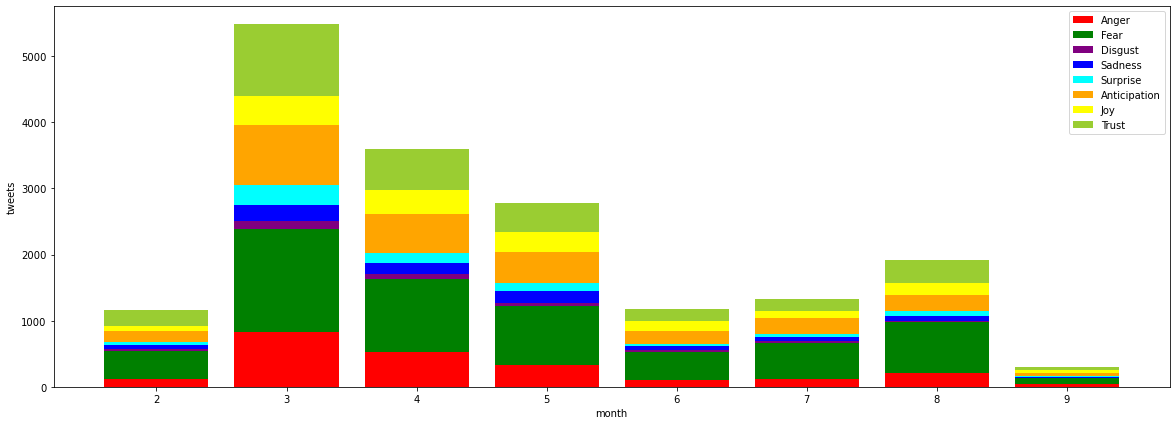

In [11]:
import numpy as np

def get_bottom(emotions):
    res = None
    for k, v in values.items():
        if k in emotions:
            if res is None:
                res = np.array(v)
            else:
                res += np.array(v)
    return res
            
plt.figure(figsize=(20, 7))
plt.bar(labels, values['Anger'], label='Anger', color='red')
plt.bar(labels, values['Fear'], label='Fear', bottom=get_bottom(['Anger']), color='green')
plt.bar(labels, values['Disgust'], label='Disgust', bottom=get_bottom(['Anger', 'Fear']), color='purple')
plt.bar(labels, values['Sadness'], label='Sadness', bottom=get_bottom(['Anger', 'Fear', 'Disgust']), color='b')
plt.bar(labels, values['Surprise'], label='Surprise', bottom=get_bottom(['Anger','Fear', 'Disgust' ,'Sadness']), color='cyan')
plt.bar(labels, values['Anticipation'], label='Anticipation', bottom=get_bottom(['Anger', 'Fear', 'Disgust', 'Sadness', 'Surprise']), color='orange')
plt.bar(labels, values['Joy'], label='Joy', bottom=get_bottom(['Anger', 'Fear', 'Disgust', 'Sadness', 'Surprise', 'Anticipation']), color='yellow')
plt.bar(labels, values['Trust'], label='Trust', bottom=get_bottom(['Anger', 'Fear', 'Disgust', 'Sadness', 'Surprise', 'Anticipation', 'Joy']), color='yellowgreen')
plt.xlabel('month')
plt.ylabel('tweets')
plt.legend()

- `Joy` is opposite `Sadness`.


- `Fear` is opposite `Anger`.


- `Anticipation` is the opposite `Surprise`.


- `Disgust` is the opposite of `Rrust`.